In [10]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import inspect
sns.set_context('talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The goal of this script is to evaluate the parameters fit by running TBA with linear regression on H3K27Ac selected ATAC Signals

### Set working directory

In [11]:
workingDirectory = '/home/h1bennet/liverStrains/results/180522_H3K27Ac_TBA/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [12]:
import scipy
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

In [13]:
tst_features = pd.read_csv('./tba_output/ncorwt_kupffertim4pos_control_0wk_peaks_features.tsv', sep='\t', index_col=0)
tst_labels = pd.read_csv('./tba_output/ncorwt_kupffertim4pos_control_0wk_peaks_labels.tsv', sep='\t',
                         index_col=0, header=None, names=['pos', 'h3k27ac'])
tst_membership = pd.read_csv('./tba_output/ncorwt_kupffertim4pos_control_0wk_peaks_membership.tsv', sep='\t',
                            index_col=0, header=None, names=['pos', 'mem'])

log2_labels = np.log(tst_labels + 1)
log2_labels = log2_labels.loc[tst_features.index.values]

In [14]:
var_b

array([  6.63501253e+00,   3.56996522e+03,   3.74817209e+03,
         4.42671488e+03,   4.28003050e+03,   1.73625494e+05,
         1.14944398e+05,   4.51701014e+04,   2.60743778e+04,
         2.95502886e+04,   4.35391634e+03])

### Evaluate Different Parameters of Alpha

In [15]:
pearson = []
coef = []
for alpha in np.arange(0, 1, 0.05):

    training_features, test_features, training_labels, test_labels = train_test_split(
        tst_features,
        log2_labels,
        train_size=0.5)

    scaler = preprocessing.StandardScaler()

    # standardize training features
    standardized_training_features = pd.DataFrame(scaler.fit_transform(training_features))
    standardized_training_features.columns = training_features.columns.values
    standardized_training_features.index = training_features.index.values

    # standardize test features
    standardized_test_features = pd.DataFrame(scaler.fit_transform(test_features))
    standardized_test_features.columns = test_features.columns.values
    standardized_test_features.index = test_features.index.values

    #  Train affinity classifier
#     classifier = sklearn.linear_model.LinearRegression(fit_intercept=False, normalize=False)
    classifier = sklearn.linear_model.Lasso(alpha=alpha,
                                            fit_intercept=False,
                                            normalize=False,
                                            max_iter=10**4)
    classifier.fit(standardized_training_features, training_labels)
    
    if not (classifier.coef_ == 0).all():
        predictions=classifier.predict(test_features)
        r, p = scipy.stats.pearsonr(predictions.flatten(), test_labels.values.flatten())
        pearson.append((alpha, r, p))
        coef.append((alpha, classifier.coef_))

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


### pearson r of correlation

In [16]:
pearson_df = pd.DataFrame(pearson, columns=['alpha', 'r', 'pval'])

Text(0,0.5,'pearson r')

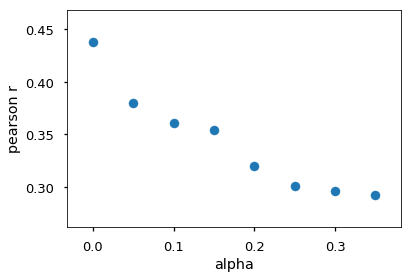

In [17]:
plt.scatter(pearson_df.alpha, pearson_df.r)
plt.xlabel('alpha')
plt.ylabel('pearson r')

### Number of parameters fit by the model

Text(0,0.5,'N params')

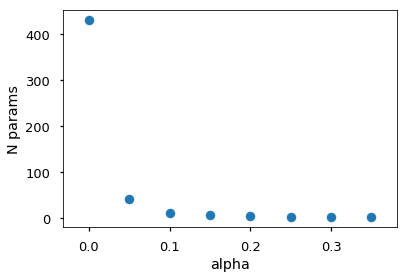

In [18]:
n_param = []
for alpha, coeffs in coef:
    n_param.append(sum([1 if val != 0 else 0 for val in coeffs]))
    
plt.scatter(pearson_df.alpha, n_param)
plt.xlabel('alpha')
plt.ylabel('N params')

In [19]:
n_param

[431, 41, 11, 6, 4, 1, 1, 1]

### Plot parameter distribution

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-0.5, 0.5)

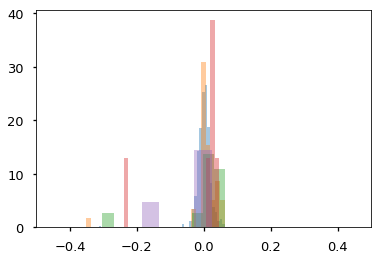

In [20]:
sns.distplot([val for val in coef[0][1] if val != 0], norm_hist=True, kde=False)
sns.distplot([val for val in coef[1][1] if val != 0], norm_hist=True, kde=False)
sns.distplot([val for val in coef[2][1] if val != 0], norm_hist=True, kde=False)
sns.distplot([val for val in coef[3][1] if val != 0], norm_hist=True, kde=False)
sns.distplot([val for val in coef[4][1] if val != 0], norm_hist=True, kde=False)

plt.xlim(xmin=-0.5, xmax=0.5)

### Look at TFs that have scores across at least four values of alpha

In [21]:
coef_df = pd.DataFrame([coeff for a, coeff in coef],
             index = ['%.2f' % a for a, coeff in coef],
             columns = tst_features.columns.values).T

In [22]:
coef_df.loc[(coef_df != 0).sum(1) > 2, :]

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35
CREB-related_factors_1_merged,0.034189,0.022006,0.004123,0.000000,0.000000,0.000000,0.000000,0.000000
CTCF,-0.314263,-0.351293,-0.302658,-0.238613,-0.184619,-0.134482,-0.091092,-0.046349
E4F1,0.033125,0.038195,0.004628,0.000000,0.000000,0.000000,0.000000,0.000000
Gmeb1,0.035761,0.045893,0.054348,0.029045,0.000000,0.000000,0.000000,0.000000
HINFP,0.032336,0.034501,0.034152,0.030264,0.003980,0.000000,0.000000,0.000000
NRF1,0.062290,0.062229,0.053752,0.045700,0.023868,0.000000,0.000000,0.000000
SP2,0.025923,0.041736,0.027430,0.014960,0.000000,0.000000,0.000000,0.000000
Three-zinc_finger_Kruppel-related_factors_3_merged,0.013798,0.002929,0.012536,0.000000,0.000000,0.000000,0.000000,0.000000
ZBTB1,0.028804,0.008311,0.008560,0.000000,0.000000,0.000000,0.000000,0.000000
ZBTB33,0.036560,0.057595,0.063480,0.027921,0.002146,0.000000,0.000000,0.000000


In [23]:
pearson_ridge = []
coef_ridge = []
for alpha in np.arange(0, 1, 0.05):

    training_features, test_features, training_labels, test_labels = train_test_split(
        tst_features,
        log2_labels,
        train_size=0.5)

    scaler = preprocessing.StandardScaler()

    # standardize training features
    standardized_training_features = pd.DataFrame(scaler.fit_transform(training_features))
    standardized_training_features.columns = training_features.columns.values
    standardized_training_features.index = training_features.index.values

    # standardize test features
    standardized_test_features = pd.DataFrame(scaler.fit_transform(test_features))
    standardized_test_features.columns = test_features.columns.values
    standardized_test_features.index = test_features.index.values

    #  Train affinity classifier
#     classifier = sklearn.linear_model.LinearRegression(fit_intercept=False, normalize=False)
    classifier = sklearn.linear_model.Ridge(alpha=alpha,
                                            fit_intercept=False,
                                            normalize=False,
                                            max_iter=10**4)
    classifier.fit(standardized_training_features, training_labels)
    
    if not (classifier.coef_ == 0).all():
        predictions=classifier.predict(test_features)
        r, p = scipy.stats.pearsonr(predictions.flatten(), test_labels.values.flatten())
        pearson_ridge.append((alpha, r, p))
        coef_ridge.append((alpha, classifier.coef_))

Text(0,0.5,'pearson r')

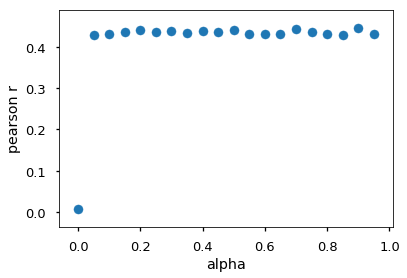

In [24]:
pearson_df = pd.DataFrame(pearson_ridge, columns=['alpha', 'r', 'pval'])
plt.scatter(pearson_df.alpha, pearson_df.r)
plt.xlabel('alpha')
plt.ylabel('pearson r')

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-0.5, 0.5)

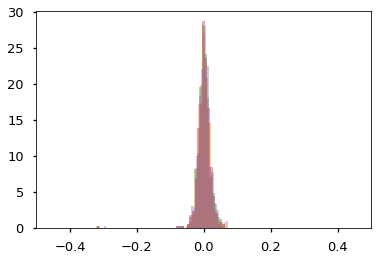

In [25]:
sns.distplot([val for val in coef_ridge[0][1].flatten() if val != 0], norm_hist=True, kde=False)
sns.distplot([val for val in coef_ridge[1][1].flatten() if val != 0], norm_hist=True, kde=False)
sns.distplot([val for val in coef_ridge[2][1].flatten() if val != 0], norm_hist=True, kde=False)
sns.distplot([val for val in coef_ridge[3][1].flatten() if val != 0], norm_hist=True, kde=False)
sns.distplot([val for val in coef_ridge[4][1].flatten() if val != 0], norm_hist=True, kde=False)

plt.xlim(xmin=-0.5, xmax=0.5)

### Explore ElasticNet - both alpha and l1 ratio